# Assignment 1: Backpropagation

In [408]:
import numpy as np

In [423]:
inputs = []
input_size = 1000

for i in range(8):
    input = np.zeros(((8+1),1)) # +1 is the bias
    input[0] = 1 # bias at the beginning of the input
    input[i+1] = 1
    inputs.append(input)

inputs = np.array(inputs*input_size)
np.random.shuffle(inputs)
print(inputs[0:2])
len(inputs)

# inputs is a 9x800 matrix, where each column in a training instance
# each unique training instance is included 100 times in the training data

[[[1.]
  [0.]
  [0.]
  [0.]
  [0.]
  [1.]
  [0.]
  [0.]
  [0.]]

 [[1.]
  [0.]
  [0.]
  [0.]
  [1.]
  [0.]
  [0.]
  [0.]
  [0.]]]


8000

In [437]:
# Let's discuss wether we want to use global variables, or wanna pass them to functions.
# Especially with the layers. Both works for me but now I changed things and it's messed up :D

# initialize the weights
# TO do Adjust this to be close to 0, e.g. Uniform distribution between 0 and 0.02!
W1 = np.random.normal(0.1, 0.1, 3*9).reshape(3, 9) # 3x9 matrix
W2 = np.random.normal(0.1, 0.1, 8*4).reshape(8, 4) # 8x4 matrix

# initialize the big Deltas (called triangles) 
# these have the same shape as the weights matrices, as they represent the gradients for each weight 
triangles1 = np.zeros((3, 9)) # 3x9 matrix
triangles2 = np.zeros((8, 4)) # 8x4 matrix

lr = 0.1 # learning rate
training_set_length = 8
weight_decay = 0.000001

def sigmoid(x):
    return (1/(1 + np.exp(-x)))

def forward_prop(input):
    hidden = sigmoid(np.dot(W1, input))
    hidden = np.insert(hidden,0,1) # insert the bias
    output = sigmoid(np.dot(W2, hidden))
    return(hidden, output)
    
def back_prop(hidden, output, expected):
    # initialize helper vectors consisting of ones
    one_8 = np.ones(8) # its shape is (8,) and not (1,8), so it works (had some problem with (8,1))
    one_4 = np.ones(4)

    # compute delta 3 and 2 ("error term" of the nodes of output and hidden layer, 
    # that measures how much that node was “responsible” for any errors in our output)
    delta3 = output * (one_8 - output) * (output - expected) # deltas in layer 3 (output)
    #         (8x1) * ((8x1) - (8x1))  *  ((8x1) - (8x1))   = (8x1)

    delta2 = hidden * (one_4 - hidden) * np.dot(W2.T, delta3) # deltas in layer 2 (hidden)
    #         (4x1) * ((4x1) - (4x1))  *  ((4x8) . (8x1))   = (4x1)
    #                                          (4x1)
    
    # Would be nicer with another function for it, which has a layer list [input, hidden, output],
    # but I think it's clearer this way (we can change it later).
    # compute the big deltas (called triangles here)
    for j in range(len(hidden)):
        for i in range(len(output)):
            triangles2[i][j] += hidden[j] * delta3[i]

    for j in range(len(input)):
        for i in range(len(hidden)-1): # we don't count the bias
            triangles1[i][j] += input[j] * delta2[i] 

def weight_tune(input, hidden, output):
    big_D1 = np.zeros((3,9))
    big_D2 = np.zeros((8,4))
    global W1, W2, triangles1, triangles2

    for j in range(len(hidden)):
        for i in range(len(output)):
            if j == 0:
                big_D2[i][j] = triangles2[i][j]/training_set_length
            else:
                big_D2[i][j] = (triangles2[i][j]/training_set_length + weight_decay * W2[i][j])


    for j in range(len(input)):
        for i in range(len(hidden)-1): # we don't count the bias
            if j == 0:
                big_D1[i][j] = triangles1[i][j]/training_set_length
            else:
                big_D1[i][j] = (triangles1[i][j]/training_set_length + weight_decay * W1[i][j])


    W1 = W1 - lr * big_D1
    W2 = W2 - lr * big_D2

    triangles1 = np.zeros((3,9))
    triangles2 = np.zeros((8,4)) 
    


    #   Okay, I figured it out. We call forward_prop and back_prop everytime we have a new input,
    #   BUT we don't tune the weights that often. This way it makes sense to add up the triangle[i][j].
    #   We tune the weights after every training set, which contains 'm' input+output.
    #   So I guess the training set does not contain ALL the 800 inputs we generated.
    #
    #   And we compute big_D: we devide by 'm' so it'd be the average of it and then we subtract
    #   the big_D (which stands for difference I guess, or it's delta again) from the weight.
    #

    #   ------------------- MY PREVIOUS SUFFERING WITH THE TRIANGLES --------------------

    #   Yo. How the fuck does the triangle work? I mean let's say there are i x j triangles,
    #   bc I guess that's what ij means. Every triangle is 0 at first and we have this:
    #   triangle = triangle + a_j(l) * d_i(l+1). But if there are i x j triangles then it
    #   happens only once, so it doesn't make any sense.
    #   My guess was what I've done up here, so we'd have a triangle for every neuron.
    #
    #   But then where we compute big_D (Harry Potter reference here hehe) it would have
    #   a point if there would be different triangle for every weight... so...
    #   we compute triangles for weights or neurons?
    #
    #   But then why is it different at the first neurons? So when j = 0, then we don't
    #   compute the learning rate * weight.
    #
    #   Or maybe the combination of both? Compute triangles for neurons, then use one
    #   neuron's triangle for every weight that comes out of it? 
    #
    #   I HAVE NO IDEA

    # new_weight = old_weight - big_D



In [438]:
i = 1
SSE = []
for input in inputs:
    hidden, output = forward_prop(input)
    expected = np.delete(input,0)
    SSE.append(np.sum((output - expected) ** 2) / 8)

    back_prop(hidden, output, expected) # we need to delete the bias
    if i % training_set_length == 0:
        weight_tune(input, hidden, output)
    i+=1


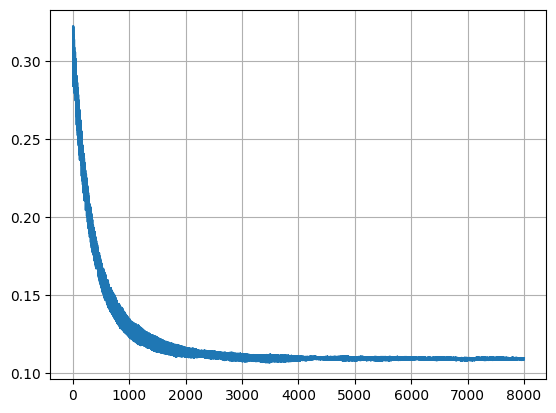

In [439]:
import matplotlib.pyplot as plt
x = []
for i in range(input_size*8):
    x.append(i+1)

plt.plot(x, SSE)
plt.grid()
plt.show()

In [440]:
print(inputs[200])

_, output = forward_prop(inputs[200])

print(output)
#print(output - expected)
np.sum((output - expected) ** 2) / 8

[[1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]]
[0.13345781 0.13481895 0.12909337 0.13196576 0.13020848 0.1310634
 0.13084551 0.12994308]


0.11000225852923111